In [1]:
import torch
import torchvision.models as models
import torch.nn as nn
from torchvision import datasets, transforms
import torch.optim as optim
from tensorboardX import SummaryWriter
from torch.optim import lr_scheduler
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

import numpy as np
from PIL import Image
import json
import os

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data_dir = "car_dam/data1a/"

train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomHorizontalFlip(),
                                      transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])

train_data = datasets.ImageFolder(data_dir + '/training', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/validation', transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=128)

In [3]:
model = models.vgg19_bn(pretrained=True)

In [4]:
from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(25088, 4096)),
                          ('dropout1', nn.Dropout(0.5)),
                          ('relu1', nn.ReLU()),
                          ('fc2', nn.Linear(4096, 2048)),
                          ('dropout2', nn.Dropout(0.5)),
                          ('relu2', nn.ReLU()),
                          ('fc3', nn.Linear(2048, 1)),
                          ('output', nn.Sigmoid())
                          ]))

model.classifier = classifier

## Freeze Layers and train only the classifier

In [5]:
for n, p in model.named_parameters():
    if n.split('.')[0] == 'classifier':
        pass
    else:
        p.requires_grad = False

count = 0
for p in model.parameters():
    if p.requires_grad:
        print(p.size())
        count += 1
print(count)

torch.Size([4096, 25088])
torch.Size([4096])
torch.Size([2048, 4096])
torch.Size([2048])
torch.Size([1, 2048])
torch.Size([1])
6


In [6]:
def validation(model, testloader, criterion):
    test_loss = 0
    accuracy = 0
    for images, labels in testloader:

        output = model.forward(images.cuda())
        labels = labels.type(torch.FloatTensor).cuda()
        test_loss += criterion(output[:,0], labels).item()
    
    return test_loss

## Train Model

In [7]:
SAVE_PATH = "Models/2_Detect/"

writer = SummaryWriter()
model = model.cuda()
criterion = nn.BCELoss().cuda()

optimizer = torch.optim.Adam(model.classifier.parameters(), lr=1e-4)

best_train_loss = 1000
best_val_loss = 1000

scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[15, 25, 40, 50], gamma=0.1)

num_epochs = 50
running_loss = 0
steps = 0
print_every = 35
log_every = 10
log_step = 0


for epoch in range(num_epochs):
    model.train()
    scheduler.step()
    for data_ in trainloader:
        steps += 1
        img, bbox = data_
        
        img = img.cuda()
        target = bbox.type(torch.FloatTensor).cuda()
        
        output = model(img)
        loss = criterion(output[:,0], target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if steps % log_every == 0:
            log_step += 1
            model.eval()

            with torch.no_grad():
                valid_loss = validation(model, testloader, criterion)
            model.train()
            
            train_loss = running_loss/log_every
            val_loss = valid_loss/len(testloader)
            
            writer.add_scalar('Training Loss', train_loss, log_step)
            writer.add_scalar('Validation Loss', val_loss, log_step)
            writer.add_scalar('Learning rate', optimizer.state_dict()['param_groups'][0]['lr'], log_step)
            
            if val_loss < best_val_loss and train_loss < best_train_loss:
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'train_loss': train_loss,
                    'val_loss': val_loss
            }, SAVE_PATH + "vgg19_bn_epoch{}_step{}.pkl".format(epoch, steps))
                best_train_loss = train_loss
                best_val_loss = val_loss
            running_loss = 0
            
        if steps % print_every == 0:
            print("Epoch: {}/{}.. ".format(epoch+1, num_epochs),
                  "Training Loss: {:.4f}.. ".format(train_loss),
                  "valid Loss: {:.4f}.. ".format(val_loss))
writer.close()

Epoch: 3/50..  Training Loss: 0.2137..  valid Loss: 0.3741.. 
Epoch: 5/50..  Training Loss: 0.1905..  valid Loss: 0.4831.. 
Epoch: 7/50..  Training Loss: 0.1712..  valid Loss: 0.3605.. 
Epoch: 10/50..  Training Loss: 0.1287..  valid Loss: 0.2111.. 
Epoch: 12/50..  Training Loss: 0.1190..  valid Loss: 0.2379.. 
Epoch: 14/50..  Training Loss: 0.1172..  valid Loss: 0.3113.. 
Epoch: 17/50..  Training Loss: 0.0841..  valid Loss: 0.2148.. 
Epoch: 19/50..  Training Loss: 0.0770..  valid Loss: 0.2303.. 
Epoch: 21/50..  Training Loss: 0.0656..  valid Loss: 0.2307.. 
Epoch: 24/50..  Training Loss: 0.0644..  valid Loss: 0.2328.. 
Epoch: 26/50..  Training Loss: 0.0438..  valid Loss: 0.2317.. 
Epoch: 28/50..  Training Loss: 0.0689..  valid Loss: 0.2244.. 
Epoch: 31/50..  Training Loss: 0.0648..  valid Loss: 0.2325.. 
Epoch: 33/50..  Training Loss: 0.0674..  valid Loss: 0.2308.. 
Epoch: 35/50..  Training Loss: 0.0647..  valid Loss: 0.2284.. 
Epoch: 38/50..  Training Loss: 0.0650..  valid Loss: 0.225

## Load Best Model

In [6]:
inf = torch.load('Models/2_Detect/vgg19_bn_epoch14_step220.pkl')
model.load_state_dict(inf['model_state_dict'])

## Inference

In [19]:
model = model.cuda()
model.eval()

y_pred = list()
y_true = list()

with torch.no_grad():
    for imgs, op in iter(testloader):
        k = model.forward(imgs.cuda())
        y_pred.extend([np.round(j[0]) for j in k.cpu().data.numpy()])
        y_true.extend(op.cpu().data.numpy())

## Confusion Matrix

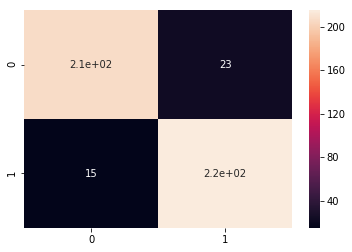

In [20]:
conf_matrix = confusion_matrix(y_pred=y_pred, y_true=y_true)
_ = sns.heatmap(conf_matrix, annot=True)

In [75]:
print(classification_report(y_true=y_true, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.87      0.99      0.93       230
           1       0.99      0.85      0.92       230

   micro avg       0.92      0.92      0.92       460
   macro avg       0.93      0.92      0.92       460
weighted avg       0.93      0.92      0.92       460



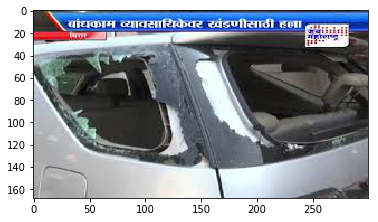

In [77]:
img = Image.open('car_dam/data1a/training/00-damage/0001.JPEG')
plt.imshow(img)

In [81]:
tensz = test_transforms(img).unsqueeze(0).cuda()
with torch.no_grad():
    print(model.forward(tensz))

tensor([[0.3193]], device='cuda:0')
